In [1]:
from IPython.display import display_html, HTML
import pyfolio as pf
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARMA
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nest_asyncio
from time import time
import plistlib
from ib_insync import IB, Future
import sys
opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)

from option_daily_prod import OptionMarket
from spx_data_update import UpdateSP500Data, SP500Index
from option_utilities import chart_format, PlotConstants
from vix_utilities import VixForecast, get_futures

nest_asyncio.apply()
futures, contract_df = get_futures('VIX')
pc = PlotConstants()
vxf = VixForecast()

vxf.plot_rolling_beta()
vxf.forecast_vix(vxf.vix_full_hist.last('10Y')) # vxf.forecast_vix(vxf.vix_full_hist.last('20Y'))
beta = vxf.vix_beta()
vxf.time_series_plots
# vxf.model_fit.summary()
column_name = futures.columns[futures.columns == vxf.vix.index[-1]]

bus_days_2_exp = np.busday_count(column_name.repeat(len(futures)).values.astype('<M8[D]'),
                 futures.index.values.astype('<M8[D]'))
bus_days_2_exp = pd.Series(data=bus_days_2_exp, index=futures.index)
weekly_index = pd.to_datetime(contract_df.loc[contract_df['localSymbol'].apply(len)>4,
                                             'lastTradeDateOrContractMonth'].values)
monthly_index = pd.to_datetime(contract_df.loc[contract_df['localSymbol'].apply(len)<=4,
                                             'lastTradeDateOrContractMonth'].values)
weekkly_futures = futures.reindex(weekly_index)


Error 162, reqId 14: Historical Market Data Service error message:HMDS query returned no data: VX18K9@CFE Trades, contract: Future(conId=356983681, symbol='VIX', lastTradeDateOrContractMonth='20190501', multiplier='1000', exchange='CFE', currency='USD', localSymbol='VX18K9', tradingClass='VX18')
Error 162, reqId 16: Historical Market Data Service error message:HMDS query returned no data: VX19K9@CFE Trades, contract: Future(conId=358967872, symbol='VIX', lastTradeDateOrContractMonth='20190508', multiplier='1000', exchange='CFE', currency='USD', localSymbol='VX19K9', tradingClass='VX19')
Error 162, reqId 17: Historical Market Data Service error message:HMDS query returned no data: VX20K9@CFE Trades, contract: Future(conId=359867721, symbol='VIX', lastTradeDateOrContractMonth='20190515', multiplier='1000', exchange='CFE', currency='USD', localSymbol='VX20K9', tradingClass='VX20')


- Link [vix_beta](https://www.zerohedge.com/news/2017-10-25/vxx-short-squeezed-vix-beta-hits-19-highest-september-2008)
for calculations of VIX beta
- Link [TWS Beta calculation](https://www.interactivebrokers.com/en/software/tws/twsguide.htm#usersguidebook/priceriskanalytics/betaweighting.htm)

In [2]:
vix_forecast = pd.Series(data=vxf.yhat[bus_days_2_exp], index=futures.index, name='Vix Forecast')

forecast_ratio = vix_forecast.to_frame().divide(futures.loc[:, column_name].squeeze(),
                                                axis=0)
premium_diff = futures.loc[:, column_name].subtract(vix_forecast,
                                                    axis=0)
premium = premium_diff.multiply(1 / bus_days_2_exp,
                                axis=0)
expected_return = (forecast_ratio.pow(1 / bus_days_2_exp,
                                     axis=0) - 1) * 10000

# expected_return.loc[monthly_index].dropna().style.format('{:.2%}')

/Users/ebellord/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


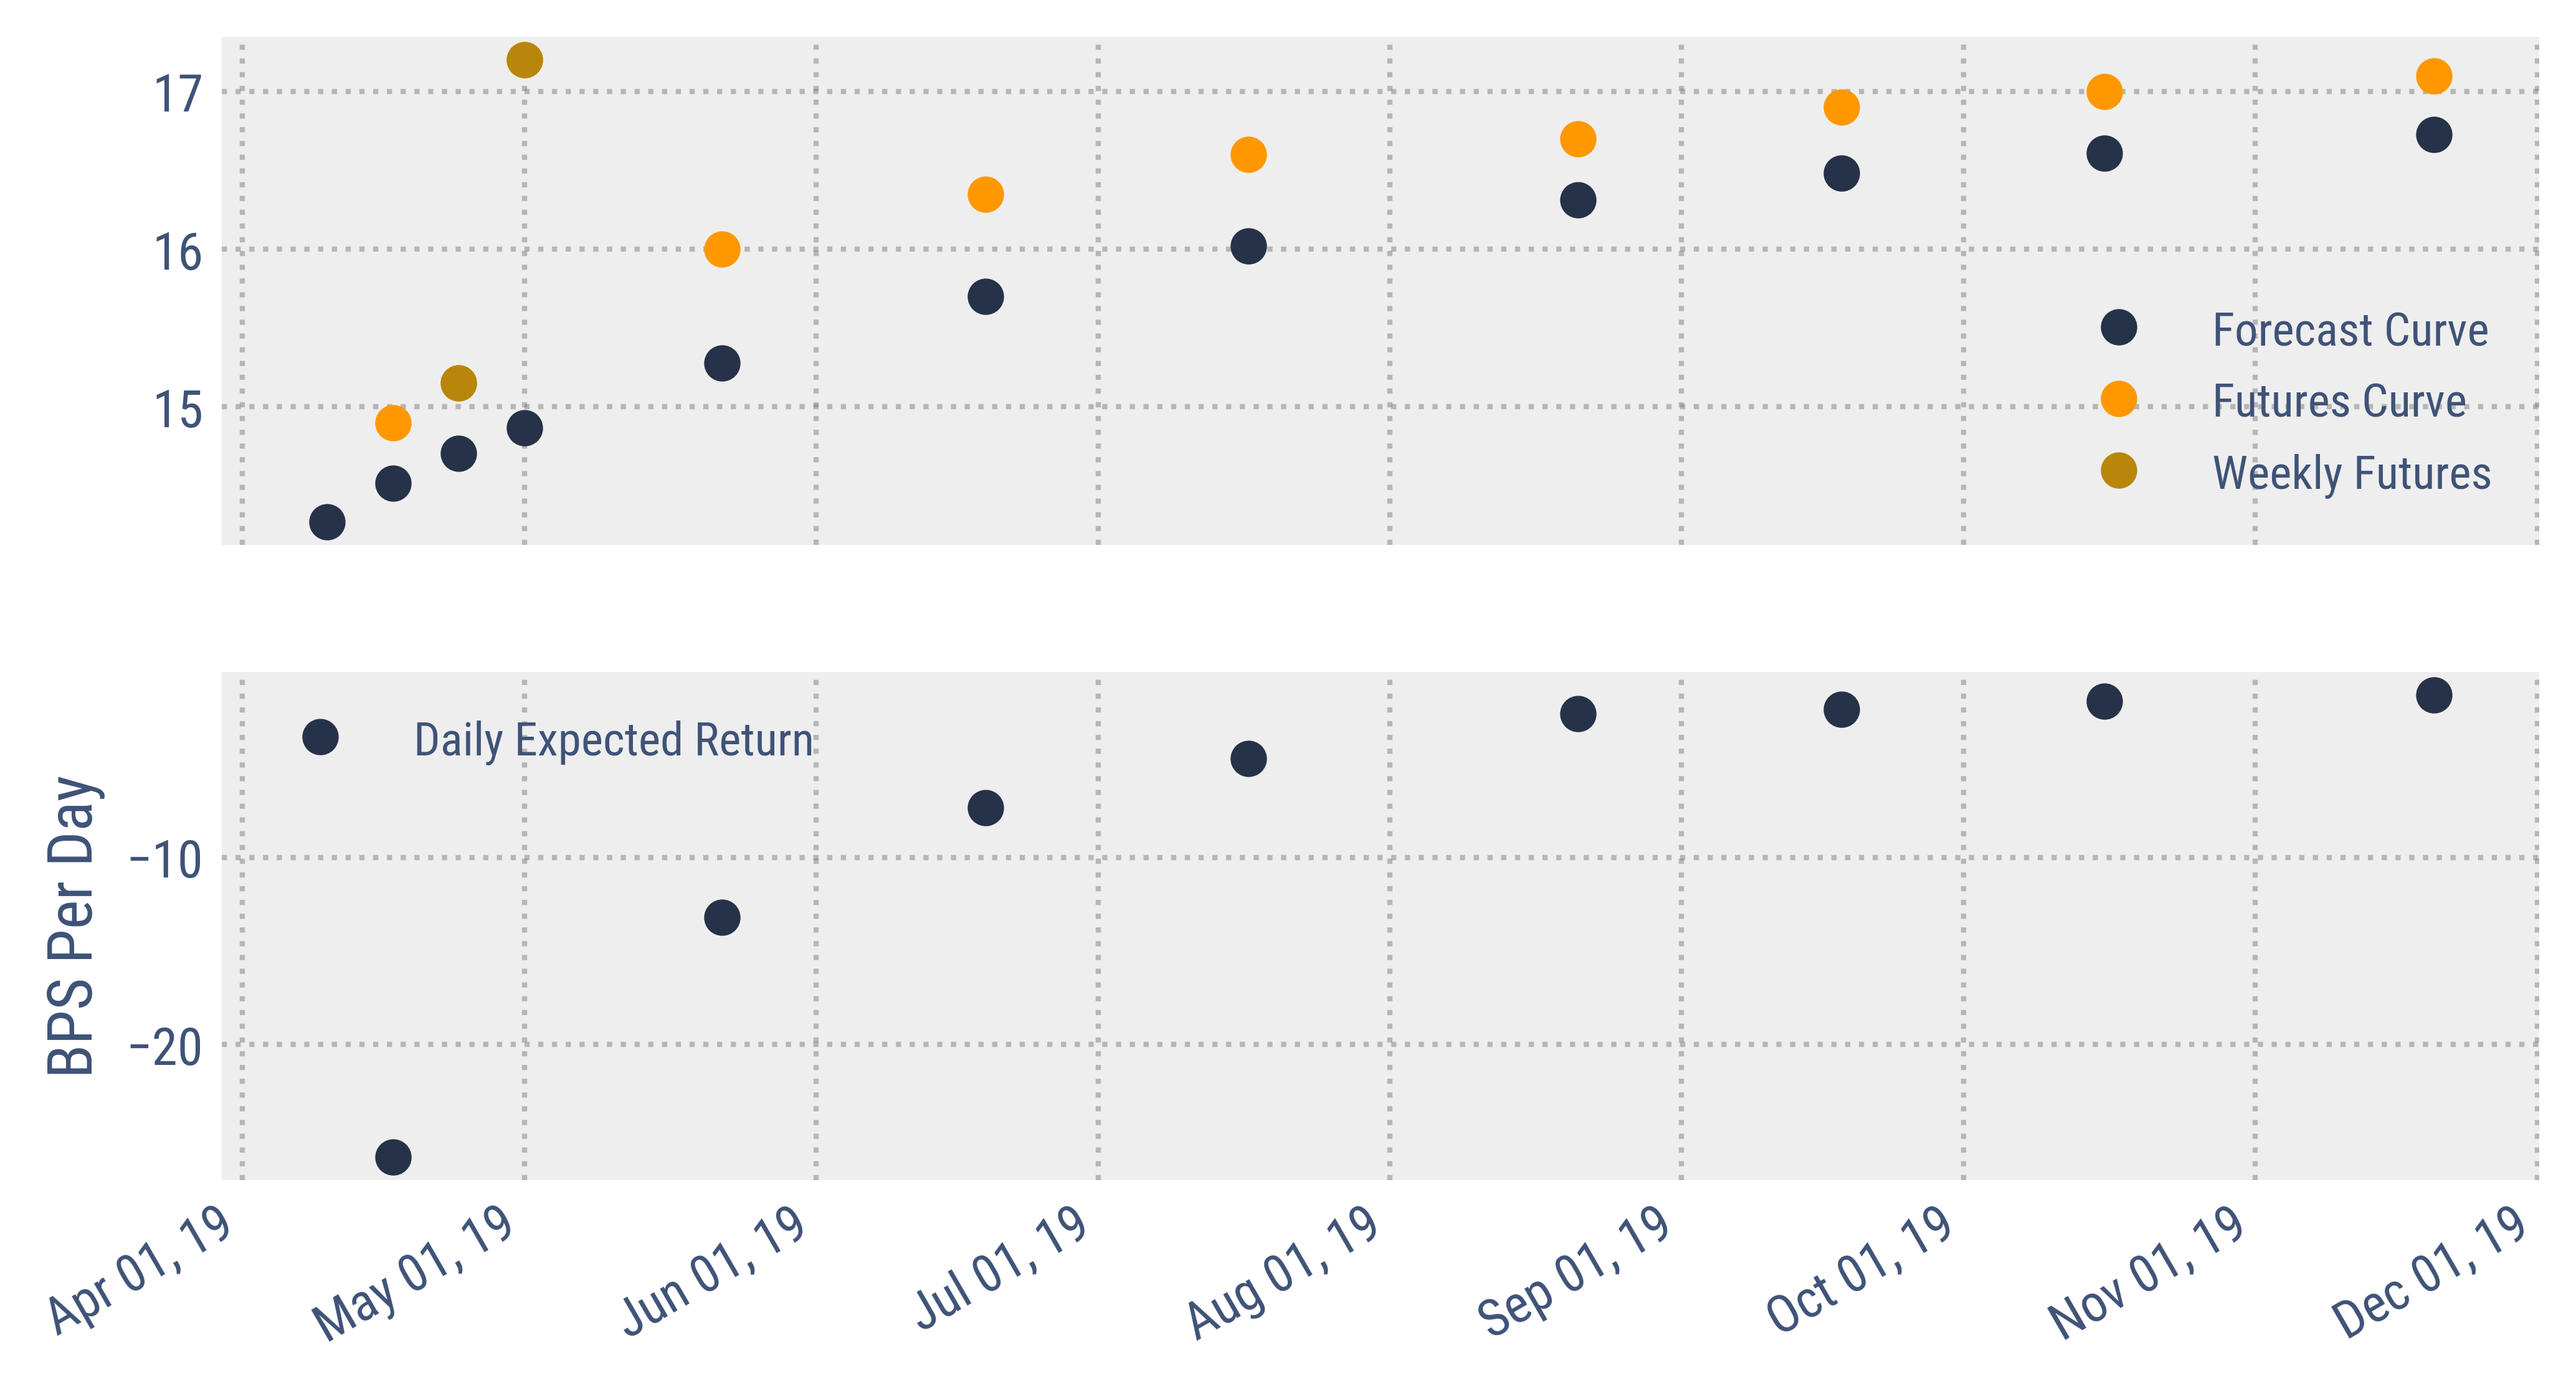

In [3]:

with plt.style.context('bmh'):
    _ = plt.figure(figsize=pc.fig_size,
                   dpi=600,
                   facecolor='None',
                   edgecolor='None')
    gs = gridspec.GridSpec(2, 1, wspace=0.5, hspace=0.25)
    ax_vix = plt.subplot(gs[0])
    ax_premium = plt.subplot(gs[1], sharex=ax_vix)
    ax_vix = vix_forecast.plot(marker='o',
                      linestyle='',
                      color=pc.color_dark,
                      ax=ax_vix)
    ax_vix = futures.reindex(columns=column_name).plot(marker='o',
                                              linestyle='',
                                              c=pc.color_yellow,
                                              ax=ax_vix)
    ax_vix = futures.reindex(index=weekly_index, columns=column_name).plot(marker='o',
                                                                  linestyle='',
                                                                  color=['#B8860B'],
                                                                  ax=ax_vix)
    lines, labels = ax_vix.get_legend_handles_labels()
    legend_1 = ax_vix.legend(lines[:],
                  ['Forecast Curve', 'Futures Curve', 'Weekly Futures'],
                  loc='best',
                  framealpha=0.0)

    expected_return.loc[monthly_index].plot(marker='o',
                          linestyle='',
                          color=pc.color_dark,
                          ax=ax_premium)
    lines, labels = ax_premium.get_legend_handles_labels()
    legend_2 = ax_premium.legend(lines[:],
                  ['Daily Expected Return'],
                  loc='best',
                  framealpha=0.0)
    ax_premium.set_ylabel('BPS Per Day')
    myFmt = mdates.DateFormatter('%b %d, %y')
    ax_premium.xaxis.set_major_formatter(myFmt)
    
    chart_format([ax_vix, ax_premium], pc.color_light)
    _ = [(text.set_size(pc.font_size), text.set_color(pc.color_light)) for text in legend_1.get_texts()+
                                                                                   legend_2.get_texts()]


In [4]:
paper_trading = False
if paper_trading:
    capital_at_risk = 1000000
    delever_constant = 9
else:
    delever_constant = 16
    ib = IB()
    ib.connect('127.0.0.1', port=4001, clientId=30)
    liquidation_value = OptionMarket._get_account_tag(ib, 'NetLiquidationByCurrency')
    ib.disconnect()
    file_name = UpdateSP500Data.DATA_BASE_PATH / 'config.plist'
    f = open(str(file_name), 'rb')
    pl = plistlib.load(f)
    illiquid_dict = pl['illiquid_equity']
    illiquid_equity = sum(illiquid_dict.values()) * 0.5
    account_value = float(liquidation_value[0][2])
    capital_at_risk = account_value + illiquid_equity

In [5]:
print('Delever constant:{}'.format(delever_constant))
effective_beta = beta[0].mean()
contract_multiplier = 1000
print('Applied S&P Beta:{:0.2f}'.format(effective_beta))
trade_grid = round((capital_at_risk / (futures.reindex(columns=column_name) * contract_multiplier))
                   / delever_constant)
trade_grid = trade_grid.dropna(how='any')
trade_grid.columns = ['Vix Contracts']
futures.reindex(columns=column_name).dropna()

trade_grid['vix_dollar_notional'] = trade_grid.multiply(futures.reindex(index=trade_grid.index, columns=column_name).squeeze()
                    * contract_multiplier, axis=0)
trade_grid['spx_notional'] = trade_grid['vix_dollar_notional'] * effective_beta
trade_grid['spx_futures'] = round(trade_grid['spx_notional'] / (277700/2))
trade_grid['Vix notional %'] = trade_grid['vix_dollar_notional'] / capital_at_risk
trade_grid['SPX notional %'] = trade_grid['spx_notional'] / capital_at_risk

display(trade_grid.style.format({'Vix Contracts': '{:.0f}',
                         'vix_dollar_notional': '${:,.0f}',
                         'spx_notional': '${:,.0f}',
                         'spx_futures':'{:.0f}',
                         'Vix notional %':'{:.1%}',
                         'SPX notional %':'{:.1%}'}))
                       


Delever constant:16
Applied S&P Beta:-7.54


,Vix Contracts,vix_dollar_notional,spx_notional,spx_futures,Vix notional %,SPX notional %
2019-04-17 00:00:00,12,"$178,800","$-1,348,173",-10,6.1%,-45.7%
2019-04-24 00:00:00,12,"$181,800","$-1,370,794",-10,6.2%,-46.5%
2019-05-01 00:00:00,11,"$189,200","$-1,426,590",-10,6.4%,-48.4%
2019-05-22 00:00:00,12,"$192,000","$-1,447,703",-10,6.5%,-49.1%
2019-06-19 00:00:00,11,"$179,850","$-1,356,090",-10,6.1%,-46.0%
2019-07-17 00:00:00,11,"$182,600","$-1,376,826",-10,6.2%,-46.7%
2019-08-21 00:00:00,11,"$183,700","$-1,385,120",-10,6.2%,-47.0%
2019-09-18 00:00:00,11,"$185,900","$-1,401,708",-10,6.3%,-47.5%
2019-10-16 00:00:00,11,"$187,000","$-1,410,002",-10,6.3%,-47.8%
2019-11-20 00:00:00,11,"$188,100","$-1,418,296",-10,6.4%,-48.1%
